#Game Searches


### Games

The two games that you can work with for this laboratory are [Mancala (the Kalah variation)](https://en.wikipedia.org/wiki/Kalah) and [Breakthrough](https://en.wikipedia.org/wiki/Breakthrough_(board_game)). It is up to you to decide which.

In Mancala, players take turns grabbing all of the stones from one house on their side of the board and sowing them counterclockwise. The objective is to end the game with the most pieces in one's scoring house. In Breakthrough, players take turns advancing pawn-like pieces on a rectangular board. The objective is to get a single piece to the opponent's end of the board. The examples below show a mid-game board state from each game.

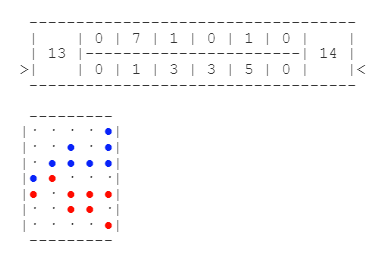




### Alpha-Beta

You should implement Minimax search with alpha-beta pruning in the PruningPlayer class. Note that alpha-beta pruning should always return the same moves that Minimax would, but it can potentially do so much more efficiently by cutting off search down branches that will not change the outcome of the search. You should make sure that your agents are exploring moves in the same order and breaking ties in the same way so that you can check the correctness of alpha-beta pruning by comparing it to standard Minimax.

```
pruning_search(state, depth, alpha, beta) # initially alpha is -inf, beta is +inf
   if depth limit reached or state is terminal
       return staticEval(state)
   # init bestValue depending on whose turn it is
   bestValue = turn * -infinity 
   for each move from state:
       determine the next_state
       # Recursive call
       value = pruning_search(next_state, depth+1, alpha, beta)
       if player is maximizer
          if value > bestValue
             bestValue = value
             if depth is 0, update bestMove to current move
          alpha = max(value, alpha)
       else # player is minimizer
          if value < bestValue
             bestValue = value
             if depth is 0, update bestMove to current move
          beta = min(value, beta)
       if alpha >= beta
          break from loop # prune remaining children
   return bestValue
```

### Evaluate Functions

You have the basic static evaluation methods implemented for both Mancala and Breakthrough.

Your static evaluators should:
- Not consider the past or future, but just evaluate the current board.
- Be efficient to calculate.
- Be deterministic (always returns the same value for the same board).
- Score terminal states correctly with maximal positive values for the first player and maximal negative values for the second player.
- Generate scores that are correlated with the chances of winning.
The comments within each basic method explain how the boards are evaluated.

Come up with an improved static evaluator for the mancala or breakthrough game and implement it in your code.

Your goal is to create an evaluator that will beat the basic evaluator function when tested using minimax players with equal depth limits.

Write a clear and thorough comment with your betterEval method to describe how it works. If you add helper functions, be sure to include comments describing these as well. You can tell your agent which static evaluator to use via the e1 and e2 parameters of run_instance. The default is to use the basic evaluator. The following command plays 2 games with agents that both search to depth 3, but use different static evaluators:

run_instance(d1=3, d2=3, e1='basic', e2='better)


### Players

In [ ]:
########################################
# NOTE: you should not need to modify this cell.
########################################

from random import choice
from sys import stdin


class HumanPlayer:
    """Player that gets moves from command line input."""
    def __init__(self, *args):
        self.name = "Human"

    def getMove(self, game):
        move = None
        while move not in game.availableMoves:
            print([move for move in game.availableMoves])
            if all(isinstance(move, int) for move in game.availableMoves):
                move = input("select a move from" + str(game.availableMoves))
                try:
                    move = int(move)
                except ValueError:
                    print("invalid move")
                if move not in game.availableMoves:
                    print("invalid move")
            else:
                print("select a move from:")
                for i,move in enumerate(game.availableMoves):
                    print(i, ":", move)
                try:
                    move = input()
                    move = game.availableMoves[int(move)]
                except (ValueError, IndexError):
                    print("invalid move")
        return move


class RandomPlayer:
    """Player that selects a random legal move."""
    def __init__(self, *args):
        self.name = "Random"

    def getMove(self, game):
        return choice(game.availableMoves)


### Games

In [ ]:
########################################
# NOTE: you should not need to modify this cell.
########################################

import numpy as np

RED   = u"\033[1;31m"
BLUE  = u"\033[1;34m"
RESET = u"\033[0;0m"
CIRCLE = u"\u25CF"

RED_DISK = RED + CIRCLE + RESET
BLUE_DISK = BLUE + CIRCLE + RESET

class Breakthrough:
    """Implements the board game Breakthrough.
    See en.wikipedia.org/wiki/breakthrough_(board_game) for rules.

    There are two ways to construct a Breakthrough instance:
    1. Initialize a new game by passing the board's height and width.
    2. Copy an existing game by specifying the game keyword.

    Attributes:
    board: An array in which +1 represents a blue piece, -1 represents a red
           piece, and 0 represents an empty space.
    turn:  Indicates which player will move next. +1 for the blue (downward-
           moving) player. -1 for the red (upward-moving) player."""
    def __init__(self, height=7, width=5, game=None):
        if game is None: # create new game
            assert width > 1
            self.board = np.zeros([height, width], dtype=int)
            self.board[:2] = 1
            self.board[-2:] = -1
            self.turn = 1
        else: # copy existing game
            self.board = game.board.copy()
            self.turn = game.turn

        self._moves = None
        self._terminal = None
        self._winner = None
        self._repr = None

    def _print_char(self, i):
        if i > 0:
            return BLUE_DISK
        if i < 0:
            return RED_DISK
        return u'\u00B7' # empty cell

    def __repr__(self):
        """A unicode representation of the board state."""
        if self._repr is None:
            self._repr = "\n".join(" ".join(map(self._print_char, row)) for row in self.board)
            self._repr += "   " + self._print_char(self.turn) + " to move\n"
        return self._repr

    def makeMove(self, move):
        """Returns a new Breakthrough instance in which move has been played.

        A valid move is a triple (row, col, dir), where row and col indicate
        the position of the piece that is moving, and dir can be -1, 0, or +1,
        indicating which of the (up to) three possible columns the piece moves
        to. For example if it is the +1 player's turn, (2,1,-1) would mean that
        the piece in row 2, column 1 moves to row 3 column 0. On player -1's
        turn, the same move would mean moving to row 1, column 0 (because
        player +1's pieces move down, while player -1's pieces move up)."""
        row, col, delta = move
        new_game = Breakthrough(game=self)
        new_game.board[row, col] = 0
        new_game.board[row + self.turn, col + delta] = self.turn
        new_game.turn *= -1
        return new_game

#The @property decorator makes it so that you can access self.availableMoves
#as a field instead of calling self.availableMoves() as a function.
    @property
    def availableMoves(self):
        """List of legal moves for the current player."""
        if self._moves is None:
            self._moves = []
            for row,col in zip(*np.where(self.board == self.turn)):
                r = row + self.turn
                if (r < 0) or (r >= self.board.shape[0]):
                    continue
                if self.board[r, col] == 0:
                    self._moves.append((row, col, 0))
                for delta in [-1,1]:
                    c = col + delta
                    if (c < 0) or (c >= self.board.shape[1]):
                        continue
                    if self.board[r,c] != self.turn:
                        self._moves.append((row, col, delta))
        return self._moves

    @property
    def isTerminal(self):
        """Boolean indicating whether the game has ended."""
        if self._terminal is None:
            if (1 in self.board[-1]) or (-1 in self.board[0]):
                self._terminal = True
            elif (1 not in self.board) or (-1 not in self.board):
                self._terminal = True
            else:
                self._terminal = False
        return self._terminal

    @property
    def winner(self):
        """+1 if the first player (maximizer) has won. -1 if the second player
        (minimizer) has won. 0 if the game is a draw. Raises an AttributeError
        if accessed on a non-terminal state."""
        if not self.isTerminal:
            raise AttributeError("Non-terminal states have no winner.")
        if self._winner is None:
            if -1 in self.board[0]:
                self._winner = -1
            elif 1 in self.board[-1]:
                self._winner = 1
            elif 1 not in self.board:
                self._winner = -1
            elif -1 not in self.board:
                self._winner = 1
        return self._winner

In [ ]:
########################################
# NOTE: you should not need to modify this cell.
########################################

import numpy as np

class Mancala:
    """Implements Kalah, a common variant of Mancala.
    See en.wikipedia.org/wiki/Kalah for rules.

    There are two ways to construct a Mancala instance:
    1. Initialize a new game by passing houses_per_player and seeds_per_house.
    2. Copy an existing game by specifying the game keyword.

    Attributes:
    houses: A (2 x houses_per_player) array that tracks the number of seeds in
            each non-scoring space on the board.
    scores: A 2-element array that tracks each player's score (end houses).
    turn:   Indicates which player will move next. +1 for the first (top row)
            player. -1 for the second (bottom row) player."""
    def __init__(self, houses_per_player=6, seeds_per_house=4, game=None):
        if game is None: # create new game
            self.houses = np.empty([2, houses_per_player], dtype=int)
            self.houses.fill(seeds_per_house)
            self.scores = np.zeros(2, dtype=int)
            self.turn = 1
        else: # copy existing game
            self.houses = game.houses.copy()
            self.scores = game.scores.copy()
            self.turn = game.turn
        self._moves = None
        self._terminal = None
        self._repr = None

    def _print_char(self, i):
        return i

    def __repr__(self):
        """An ascii representation of the board state."""
        if self._repr is None:
            # Player 0 scoring area
            if self.turn == 1:
                rows = [" --", ">| ", " | ", " | ", " --"]
            else:
                rows = [" --", " | ", " | ", ">| ", " --"]
            rows[2] += str(self.scores[0]) + " |"
            for r in [0,4]:
                rows[r] += "-"*(len(str(self.scores[0])) + 2)
            for r in [1,3]:
                rows[r] += " "*len(str(self.scores[0])) + " |"
            # houses
            for h in range(self.houses.shape[1]):
                width = len(str(self.houses[:,h].max()))
                for r in [1,3]:
                    rows[r] += " " + str(self.houses[r//2,h])
                    rows[r] += " "*(width - len(str(self.houses[r//2,h]))) +" |"
                for r in [0,2,4]:
                    rows[r] += "-"*(width + 3)
            rows[2] = rows[2][:-1] + "|"
            # player 1 scoring area
            rows[2] += " " + str(self.scores[1]) + " |\n"
            for r in [0,4]:
                rows[r] += "-"*(len(str(self.scores[1])) + 2) + "\n"
            for r in [1,3]:
                rows[r] += " "*len(str(self.scores[1])) + "  |"
            if self.turn == 1:
                rows[1] += "<\n"
                rows[3] += "\n"
            else:
                rows[1] += "\n"
                rows[3] += "<\n"
        self.__repr = "".join(rows)
        return self.__repr

    def makeMove(self, move):
        """Returns a new Mancala instance in which move has been played.

        A valid move is the index (column) of a house in which the current
        player has seeds. Seeds in that house are sown counter-clockwise
        until they run out, at which point a capture may occur."""
        new_game = Mancala(game=self)
        new_game.houses = self.houses.copy()
        side = 0 if self.turn == 1 else 1 # start sowing in row 0 or row 1
        start_side = side
        house = move

        # grab seeds
        seeds = self.houses[side, move]
        size = self.houses.shape[1]
        new_game.houses[side, move] = 0

        while seeds > 0: # sow
            if side == 0:
                house -= 1
            else:
                house += 1
            if (house == -1) or (house == size): # reached end of side
                if side == start_side: # sow in the scoring pile
                    new_game.scores[side] += 1
                    seeds -= 1
                    if seeds == 0:
                        break
                side = (side + 1) % 2
                if side == 1:
                    house += 1
                else:
                    house -= 1
            new_game.houses[(side, house)] += 1
            seeds -= 1

        if (house == -1) or (house == size):
            new_game.turn = self.turn # take another turn
        else:
            new_game.turn = -self.turn
            # check for capture
            if side == start_side and new_game.houses[(side, house)] == 1:
                captured_house = ((side + 1) % 2, house)
                if new_game.houses[captured_house] != 0:
                    new_game.scores[side] += new_game.houses[captured_house] + 1
                    new_game.houses[(side, house)] = 0
                    new_game.houses[captured_house] = 0

        # check for empty sides
        if new_game.houses[0].sum() == 0:
            new_game.scores[1] += new_game.houses[1].sum()
            new_game.houses[1] = 0
            new_game._terminal = True
        elif new_game.houses[1].sum() == 0:
            new_game.scores[0] += new_game.houses[0].sum()
            new_game.houses[0] = 0
            new_game._terminal = True

        return new_game

#The @property decorator makes it so that you can access self.availableMoves
#as a field instead of calling self.availableMoves() as a function.
    @property
    def availableMoves(self):
        """List of legal moves for the current player."""
        if self._moves is None:
            side = 0 if self.turn == 1 else 1
            self._moves = [int(m) for m in np.nonzero(self.houses[side])[0]]
        return self._moves

    @property
    def isTerminal(self):
        """Boolean indicating whether the game has ended."""
        if self._terminal is None:
            if self.scores.max() > (self.houses.sum() + self.scores.sum()) // 2:
                self._terminal = True
            elif self.houses.sum() == 0:
                self._terminal = True
            else:
                self._terminal = False
        return self._terminal

    @property
    def winner(self):
        """+1 if the first player (maximizer) has won. -1 if the second player
        (minimizer) has won. 0 if the game is a draw. Raises an AttributeError
        if accessed on a non-terminal state."""
        if not self.isTerminal:
            raise AttributeError("Non-terminal states have no winner.")
        if self.scores[0] > self.scores[1]:
            return 1
        elif self.scores[1] > self.scores[0]:
            return -1
        return 0

### Evaluate Functions - Implement better evaluate


In [ ]:
def mancalaBasicEval(mancala_game):
    """Difference between the scores for each player.
    Returns +(max possible score) if player +1 has won.
    Returns -(max possible score) if player -1 has won.
    Otherwise returns (player +1's score) - (player -1's score).
    Remember that the number of houses and seeds may vary."""
    if(mancala_game.isTerminal):
        if mancala_game.winner == 1:
            return mancala_game.scores.max()
        elif mancala_game.winner == -1:
            return -1*mancala_game.scores.max()
        else:
            return 0
    else:
        return mancala_game.scores[0] - mancala_game.scores[1]

def breakthroughBasicEval(breakthrough_game):
    """Measures how far each player's pieces have advanced
    and returns the difference.
    Returns +(max possible advancement) if player +1 has won.
    Returns -(max possible advancement) if player -1 has won.
    Otherwise finds the rank of each piece (number of rows onto the board it
    has advanced), sums these ranks for each player, and
    returns (player +1's sum of ranks) - (player -1's sum of ranks).
    An example on a 5x3 board:
    ------------
    |  0  1  1 |  <-- player +1 has two pieces on rank 1
    |  1 -1  1 |  <-- +1 has two pieces on rank 2; -1 has one piece on rank 4
    |  0  1 -1 |  <-- +1 has (1 piece * rank 3); -1 has (1 piece * rank 3)
    | -1  0  0 |  <-- -1 has (1*2)
    | -1 -1 -1 |  <-- -1 has (3*1)
    ------------
    sum of +1's piece ranks = 1 + 1 + 2 + 2 + 3 = 9
    sum of -1's piece ranks = 1 + 1 + 1 + 2 + 3 + 4 = 12
    state value = 9 - 12 = -3
    Remember that the height and width of the board may vary."""
    if(breakthrough_game.isTerminal):
        if(breakthrough_game.winner==1):
            return len(breakthrough_game.board)*len(breakthrough_game.board[0])
        elif(breakthrough_game.winner==-1):
            return -1*len(breakthrough_game.board)*len(breakthrough_game.board[0])
        else:
            return 0
    else:
        board = breakthrough_game.board
        player1 = 0
        player2 = 0
        for row in range(len(board)):
            for col in range(len(board[0])):
                if(board[row][col] == 1):
                    player1 += (row+1)
                elif(board[row][col] ==-1):
                    player2 += (len(board)-row)
        return (player1 - player2)

def mancalaBetterEval(mancala_game):
    """A heuristic that generally wins agains mancalaBasicEval.
    This must be a static evaluation function (no search allowed).
    This heuristic takes into account the available moves that will
    capture the opponent's marbles. This would be 1 + the number of marbles
    on the other side and this is added to the player1 or player2. This
    heuristic also finds the number of marbles on each side of the board for
    the respective players.
    Returns +/-(max score + #marbles on side + #marbles from capturing moves)
    if player 1/2 wins.
    otherwise returns the difference between their scores + difference between
    number of marbles on their sides + difference between number of marbles
    from capturing moves + difference between moves that will grant an extra
    move
    """
    marblesSide1 = sum(mancala_game.houses[0])
    marblesSide2 = sum(mancala_game.houses[1])
    marblesDifference = marblesSide1 - marblesSide2

    player1 = 0
    player2 = 0
    for i in range(len(mancala_game.houses[0])):
        if(mancala_game.houses[0][i]%(len(mancala_game.houses[0])*2+2)<=i):
            if(mancala_game.houses[1][i]!=0 and mancala_game.houses[0][i]!=0):
                player1+=mancala_game.houses[1][i]+1
        if(mancala_game.houses[1][i]%(len(mancala_game.houses[0])*2+2)<len(mancala_game.houses[0])-i):
            if(mancala_game.houses[1][i]!=0 and mancala_game.houses[0][i]!=0):
                player2+=mancala_game.houses[0][i]+1
        if mancala_game.houses[0][i] == i+1:
            player1 += 2
        if mancala_game.houses[1][i] == len(mancala_game.houses[0]) -  i:
            player2 += 2
    if(mancala_game.isTerminal):
        if mancala_game.winner == 1:
            return mancala_game.scores.max() + marblesSide1 + player1
        elif mancala_game.winner == -1:
            return -1*(mancala_game.scores.max()+marblesSide2 + player2)
        else:
            return 0
    else:
        return (mancala_game.scores[0] - mancala_game.scores[1] + player1 - player2 + marblesDifference)

def breakthroughBetterEval(breakthrough_game):
    """A heuristic that generally wins agains breakthroughBasicEval.
    This must be a static evaluation function (no searchin allowed).
    Measures how far each player's pieces have advanced
    and returns the difference. However, more weight is given to
    pieces that are further towards the other side
    Returns +(max possible advancement)**3 if player +1 has won.
    Returns -(max possible advancement)**3 if player -1 has won.
    Otherwise finds the rank of each piece (number of rows onto the board it
    has advanced), sums these ranks for each player, subtracts if the move will
    result in the piece being capture, and returns
    (player+1's sum of ranks (rank is 0 if the move results in piece captured))**3
    - (player-1's sum of ranks (rank is 0 if the move results in piece captured))**3."""
    if(breakthrough_game.isTerminal):
        if(breakthrough_game.winner == 1):
            return (len(breakthrough_game.board)*len(breakthrough_game.board[0]))
        else:
            return -1*((len(breakthrough_game.board)*len(breakthrough_game.board[0])))
    else:
        board = breakthrough_game.board
        player1 = 0
        player2 = 0
        for row in range(len(board)):
            for col in range(len(board[0])):
                if(board[row][col] == 1):
                    player1 += ((row+1)**3)
                    if((row < (len(board)-3)) and col > 0 and col < len(board[0])-1):
                        if((board[row+2][col+1] == -1) or (board[row+2][col-1] == -1) or (board[row+3][col+1] == -1) or (board[row+3][col-1] == -1)):
                            player1 -= (row+1)**3

                elif(board[row][col] == -1):
                    player2 += ((len(board)-row)**3)
                    if((row > 3) and col > 0 and col < len(board[0])-1):
                        if((board[row-2][col+1] == 1) or (board[row-2][col-1] == 1) or (board[row-3][col+1] == 1) or (board[row-3][col-1] == 1)):
                            player2 -= (len(board)-row)**3

        return (player1-player2)

### Min Max, Alpha Beta players - Implement Alpha Beta

In [ ]:
from math import inf
class MinMaxPlayer:
    """Gets moves by depth-limited min-max search."""
    def __init__(self, boardEval, depthBound):
        self.name = "MinMax"
        self.boardEval = boardEval
        self.depthBound = depthBound

    def getMove(self, game_state):
        best_value, best_move = self.bounded_min_max(game_state, 0)
        return best_move


    def bounded_min_max(self, state, depth):
        if(state.isTerminal or self.depthBound == depth):
            return self.boardEval(state), None
        # best_value = self.boardEval(state)
        if(state.turn==1):
            best_value = -1*inf
        else:
            best_value = inf
        best_move = None
        for move in state.availableMoves:
            next_state = state.makeMove(move)
            value, boundedMove = self.bounded_min_max(next_state, depth+1)
            # if(value == None):
            #     continue
            if(state.turn==1):
                if(value > best_value):
                    best_value = value
                    best_move = move
            else:
                if(value < best_value):
                    best_value = value
                    best_move = move
        return best_value, best_move



class PruningPlayer:
    """Gets moves by depth-limited min-max search with alpha-beta pruning."""
    def __init__(self, boardEval, depthBound):
        self.name = "Pruning"
        self.boardEval = boardEval
        self.depthBound = depthBound

    def getMove(self, game_state):
        best_value, best_move = self.alpha_beta(game_state, inf, -1*inf, 0)
        return best_move

    def alpha_beta(self, state, UB, LB, depth):
        # Implement this method
        if(state.isTerminal or self.depthBound == depth):
            return self.boardEval(state), None
        if(state.turn==1):
            best_value = -1*inf
        else:
            best_value = inf
        best_move = None
        for move in state.availableMoves:
            next_state = state.makeMove(move)
            value, boundedMove = self.alpha_beta(next_state, UB, LB, depth+1)
            if(state.turn==1):
                if(value >= UB):
                    return value, boundedMove
                if(value > LB):
                    LB = value
                if(value > best_value):
                    best_value = value
                    best_move = move
            else:
                if(value <= LB):
                    return value, boundedMove
                if(value < UB):
                    UB = value
                if(value < best_value):
                    best_value = value
                    best_move = move
        return best_value, best_move
        raise NotImplementedError

### Play Game code

In [ ]:
########################################
# NOTE: you should not need to modify this cell.
########################################
import time
from argparse import ArgumentParser

games = {"mancala":Mancala,
         "breakthrough":Breakthrough}

eval_options = ["basic", "better"]
eval_functions = {"mancala":{"basic":mancalaBasicEval,
                             "better":mancalaBetterEval},
             "breakthrough":{"basic":breakthroughBasicEval,
                             "better":breakthroughBetterEval}}


players = {"random":RandomPlayer,
           "human":HumanPlayer,
           "minmax":MinMaxPlayer,
           "pruning":PruningPlayer,
           "tournament":"tournament",
           "friend":"friend"}

class GameArguments:
    def __init__(self, game='mancala', number_of_matches=1, p1='minmax', p2='minmax', e1='basic', e2='better', d1=4, d2=4, show=True):
        self.game = game
        self.games = number_of_matches
        self.p1 = p1
        self.p2 = p2
        self.e1 = e1
        self.e2 = e2
        self.d1 = d1
        self.d2 = d2
        self.show = show
        self.game_args = []


def play_game(game, player1, player2, show=False):
    """Plays a game then returns the final state."""
    while not game.isTerminal:
        if show:
            print(game)
        if game.turn == 1:
            m = player1.getMove(game)
        else:
            m = player2.getMove(game)
        if m not in game.availableMoves:
            raise Exception("invalid move: " + str(m))
        game = game.makeMove(m)
    if show:
        print(game, "\n")
        if game.winner != 0:
            print("player", game._print_char(game.winner), "wins")
        else:
            print("it's a draw")

    return game


def run_instance(game='mancala', number_of_matches=1, p1='minmax', p2='minmax', e1='basic', e2='basic', d1=4, d2=4, show=True):
    args = GameArguments(game, number_of_matches, p1, p2, e1, e2, d1, d2, show)
    if args.p1 == "tournament":
        p1 = tournament_players[args.game]()
    elif args.p1 == "friend":
        p1 = friend_players[args.game]()
    elif args.p1 == "minmax" or args.p1 == "pruning":
        e1 = eval_functions[args.game][args.e1]
        p1 = players[args.p1](e1, args.d1)
    else:
        p1 = players[args.p1]()
    if args.p2 == "tournament":
        p2 = tournament_players[args.game]()
    elif args.p2 == "friend":
        p2 = friend_players[args.game]()
    elif args.p2 == "minmax" or args.p2 == "pruning":
        e2 = eval_functions[args.game][args.e2]
        p2 = players[args.p2](e2, args.d2)
    else:
        p2 = players[args.p2]()
    game = games[args.game](*args.game_args)

    if args.games == 1:
        played_game = play_game(game, p1, p2, args.show)
        return played_game
    else:
        played_games = []
        p1_wins = 0
        p2_wins = 0
        draws = 0
        for i in range(args.games):
            if i % 2:
                result = play_game(game, p1, p2, args.show)
                if result.winner == 1:
                    p1_wins += 1
                elif result.winner == -1:
                    p2_wins += 1
                else:
                    draws += 1
            else:
                result = play_game(game, p2, p1, args.show)
                if result.winner == -1:
                    p1_wins += 1
                elif result.winner == 1:
                    p2_wins += 1
                else:
                    draws += 1
            played_games.append(result)
        print("results after", args.games, "games:")
        print(p1_wins, "wins for player 1 (" + p1.name + ")")
        print(p2_wins, "wins for player 2 (" + p2.name + ")")
        if draws > 0:
            print(draws, "draws")
    return played_games


### Play yourself / Test your players

In [ ]:
# Run run_instance() in order to play a game of mancala / breakthrough and test your players
# game - 'mancala' or 'breakthrough'
# number_of_matches - int, decides how many matches should be played (usually 1, can change to any number if you want to bulk-test a specific set-up)
# p1 - player 1 type (human - allows user to play, random, minmax, pruning)
# p2 - player 2 type (human - allows user to play, random, minmax, pruning)
# e1 - evaluator used by player 1 (basic, better)
# e2 - evaluator used by player 2 (basic, better)
# d1 - depth to which player 1 should perform his search. Note that depth exponentially increases total search time.
# d2 - depth to which player 2 should perform his search
# show - whether to show all steps/moves performed during the game (True/False)

run_instance()  # run_instance will run with following parameters by default: game='mancala', number_of_matches=1, p1='minmax', p2='minmax', e1='basic', e2='basic', d1=4, d2=4, show=True

# run_instance(game='mancala', p1='human', p2='minmax') # Example of human playing, uncomment to play
# run_instance(game='breakthrough', number_of_matches=1, p1='human', p2='minmax', d2=3, e2='basic', show=True)


 --------------------------------
>|   | 4 | 4 | 4 | 4 | 4 | 4 |   |<
 | 0 |-----------------------| 0 |
 |   | 4 | 4 | 4 | 4 | 4 | 4 |   |
 --------------------------------

 --------------------------------
 |   | 0 | 4 | 4 | 4 | 4 | 4 |   |
 | 1 |-----------------------| 0 |
>|   | 5 | 5 | 5 | 4 | 4 | 4 |   |<
 --------------------------------

 --------------------------------
 |   | 0 | 4 | 4 | 4 | 4 | 4 |   |
 | 1 |-----------------------| 1 |
>|   | 5 | 0 | 6 | 5 | 5 | 5 |   |<
 --------------------------------

 --------------------------------
>|   | 0 | 4 | 4 | 4 | 4 | 4 |   |<
 | 1 |-----------------------| 1 |
 |   | 0 | 1 | 7 | 6 | 6 | 6 |   |
 --------------------------------

 --------------------------------
 |   | 1 | 0 | 4 | 4 | 4 | 4 |   |
 | 2 |-----------------------| 1 |
>|   | 1 | 2 | 7 | 6 | 6 | 6 |   |<
 --------------------------------

 --------------------------------
>|   | 1 | 0 | 4 | 5 | 5 | 5 |   |<
 | 2 |-----------------------| 2 |
 |   | 1 | 2 | 0 | 7

 ----------------------------------
>|    | 0 | 0 | 0 | 0 | 0 | 0 |    |<
 | 23 |-----------------------| 25 |
 |    | 0 | 0 | 0 | 0 | 0 | 0 |    |
 ----------------------------------

### Mancala Tests

In [ ]:
# Mancala Tests

test_list = []

def test_pruning_speed_fast():
    start = time.time()
    result_minmax_game = run_instance(p1='minmax', p2='minmax', d1=4, d2=4, show=False)
    end = time.time()
    minmax_time_d_4 = end - start
    start = time.time()
    result_alpha_beta_game = run_instance(p1='pruning', p2='pruning', d1=4, d2=4, show=False)
    end = time.time()
    alpha_beta_time_d_4 = end - start
    print('minmax depth 4:', round(minmax_time_d_4, 5), 'seconds,', 'alpha beta depth 4:', round(alpha_beta_time_d_4, 5), 'seconds')

    result_minmax_game = str(result_minmax_game)
    result_alpha_beta_game = str(result_alpha_beta_game)

    if result_minmax_game == result_alpha_beta_game and minmax_time_d_4 > 2 * alpha_beta_time_d_4:
        return True
    return False


def test_pruning_speed_d5mm_d6ab():
    start = time.time()
    result_minmax_game = run_instance(p1='minmax', p2='minmax', d1=5, d2=5, show=False)
    end = time.time()
    minmax_time_d_5 = end - start
    start = time.time()
    result_alpha_beta_game = run_instance(p1='pruning', p2='pruning', d1=6, d2=6, show=False)
    end = time.time()
    alpha_beta_time_d_6 = end - start
    print('minmax depth 5:', round(minmax_time_d_5, 5), 'seconds', 'alpha beta depth 6:', round(alpha_beta_time_d_6, 5), 'seconds')

    result_minmax_game = str(result_minmax_game)
    result_alpha_beta_game = str(result_alpha_beta_game)
    
    if minmax_time_d_5 > alpha_beta_time_d_6:  
        return True
    return False


def test_pruning_speed_d5mm_d7ab():
    start = time.time()
    result_minmax_game = run_instance(p1='minmax', p2='minmax', d1=5, d2=5, show=False)
    end = time.time()
    minmax_time_d_5 = end - start
    start = time.time()
    result_alpha_beta_game = run_instance(p1='pruning', p2='pruning', d1=5, d2=7, show=False)
    end = time.time()
    alpha_beta_time_d_7 = end - start
    print('minmax depth 5:', round(minmax_time_d_5, 5), 'seconds', 'alpha beta depth 7:', round(alpha_beta_time_d_7, 5), 'seconds')

    result_minmax_game = str(result_minmax_game)
    result_alpha_beta_game = str(result_alpha_beta_game)

    if minmax_time_d_5 > alpha_beta_time_d_7:
        return True
    return False


def test_mancala_better_evaluate():
    result_minmax_game1 = run_instance(number_of_matches=1, p1='minmax', p2='minmax', d1=3, d2=3, e1='basic', e2='better', show=False) # Test better > basic for same depth
    result_minmax_game2 = run_instance(number_of_matches=1, p1='minmax', p2='minmax', d1=4, d2=4, e1='basic', e2='better', show=False)
    result_minmax_game3 = run_instance(number_of_matches=1, p1='minmax', p2='minmax', d1=5, d2=5, e1='basic', e2='better', show=False)
    result_minmax_game4 = run_instance(number_of_matches=1, p1='minmax', p2='minmax', d1=3, d2=3, e1='better', e2='basic', show=False)
    result_minmax_game5 = run_instance(number_of_matches=1, p1='minmax', p2='minmax', d1=4, d2=4, e1='better', e2='basic', show=False)
    result_minmax_game6 = run_instance(number_of_matches=1, p1='minmax', p2='minmax', d1=4, d2=5, e1='better', e2='basic', show=False) # Test better_d4 > basic_d5
    result_minmax_game7 = run_instance(number_of_matches=1, p1='minmax', p2='minmax', d1=4, d2=3, e1='better', e2='better', show=False) # Test better_d4 > better_d3
    result_lst = [result_minmax_game1, result_minmax_game2, result_minmax_game3, result_minmax_game4, result_minmax_game5, result_minmax_game6, result_minmax_game7]
    passed_lst = []
    for idx, result in enumerate(result_lst):
        if idx < 3:
            if result.winner == -1:
                passed_lst.append('passed')
            else:
                passed_lst.append('failed')
        else:
            if result.winner == 1:
                passed_lst.append('passed')
            else:
                passed_lst.append('failed')    

    for idx, passed_status in enumerate(passed_lst):
        print('Subtest', idx + 1, passed_status)
    if passed_lst.count('passed') > 5:
        return True
    return False


def test_mancala_better_evaluate_perfect():
    result_minmax_game1 = run_instance(number_of_matches=1, p1='minmax', p2='minmax', d1=3, d2=3, e1='basic', e2='better', show=False) # Test better > basic for same depth
    result_minmax_game2 = run_instance(number_of_matches=1, p1='minmax', p2='minmax', d1=4, d2=4, e1='basic', e2='better', show=False)
    result_minmax_game3 = run_instance(number_of_matches=1, p1='minmax', p2='minmax', d1=5, d2=5, e1='basic', e2='better', show=False)
    result_minmax_game4 = run_instance(number_of_matches=1, p1='minmax', p2='minmax', d1=3, d2=3, e1='better', e2='basic', show=False)
    result_minmax_game5 = run_instance(number_of_matches=1, p1='minmax', p2='minmax', d1=4, d2=4, e1='better', e2='basic', show=False)
    result_minmax_game6 = run_instance(number_of_matches=1, p1='minmax', p2='minmax', d1=4, d2=5, e1='better', e2='basic', show=False) # Test better_d4 > basic_d5
    result_minmax_game7 = run_instance(number_of_matches=1, p1='minmax', p2='minmax', d1=4, d2=3, e1='better', e2='better', show=False) # Test better_d4 > better_d3
    result_lst = [result_minmax_game1, result_minmax_game2, result_minmax_game3, result_minmax_game4, result_minmax_game5, result_minmax_game6, result_minmax_game7]
    passed_lst = []
    for idx, result in enumerate(result_lst):
        if idx < 3:
            if result.winner == -1:
                passed_lst.append('passed')
            else:
                passed_lst.append('failed')
        else:
            if result.winner == 1:
                passed_lst.append('passed')
            else:
                passed_lst.append('failed')    

    for idx, passed_status in enumerate(passed_lst):
        print('Subtest', idx + 1, passed_status)
    print('')
    if passed_lst.count('passed') == 7:
        return True
    return False


test_list.append(test_pruning_speed_fast)
test_list.append(test_pruning_speed_d5mm_d6ab)
test_list.append(test_pruning_speed_d5mm_d7ab)
test_list.append(test_mancala_better_evaluate)
# test_list.append(test_mancala_better_evaluate_perfect) # Uncomment this if you think you've come up with a very good evaluate function

test_results = []
for idx, test in enumerate(test_list):
    try:
        test_result = test()
        test_results.append(test_result)
        if test_result:
            print('Test', idx + 1, '/', len(test_list), 'passed.')
        else:
            print('Test', idx + 1, '/', len(test_list), 'failed. Expected Alpha Beta to perform better.')
    except NotImplementedError:
        print('Test', idx + 1, '/', len(test_list), 'failed', 'Alpha Beta not implemented')
    print('')
print(test_results.count(True), 'tests passed out of', len(test_list), 'tests')

minmax depth 4: 0.45114 seconds, alpha beta depth 4: 0.13115 seconds
Test 1 / 4 passed.

minmax depth 5: 2.01803 seconds alpha beta depth 6: 1.36026 seconds
Test 2 / 4 passed.

minmax depth 5: 2.04792 seconds alpha beta depth 7: 1.50837 seconds
Test 3 / 4 passed.

Subtest 1 passed
Subtest 2 passed
Subtest 3 failed
Subtest 4 passed
Subtest 5 passed
Subtest 6 passed
Subtest 7 passed
Test 4 / 4 passed.

4 tests passed out of 4 tests


### Breakthrough Tests

In [ ]:
# Breakthrough Tests

test_list = []

def test_pruning_speed_fast():
    start = time.time()
    result_minmax_game = run_instance(p1='minmax', p2='minmax', d1=4, d2=4, show=False)
    end = time.time()
    minmax_time_d_4 = end - start
    start = time.time()
    result_alpha_beta_game = run_instance(p1='pruning', p2='pruning', d1=4, d2=4, show=False)
    end = time.time()
    alpha_beta_time_d_4 = end - start
    print('minmax depth 4:', round(minmax_time_d_4, 5), 'seconds,', 'alpha beta depth 4:', round(alpha_beta_time_d_4, 5), 'seconds')

    result_minmax_game = str(result_minmax_game)
    result_alpha_beta_game = str(result_alpha_beta_game)

    if result_minmax_game == result_alpha_beta_game and minmax_time_d_4 > 2 * alpha_beta_time_d_4:
        return True
    return False


def test_pruning_speed_d5mm_d6ab():
    start = time.time()
    result_minmax_game = run_instance(p1='minmax', p2='minmax', d1=5, d2=5, show=False)
    end = time.time()
    minmax_time_d_5 = end - start
    start = time.time()
    result_alpha_beta_game = run_instance(p1='pruning', p2='pruning', d1=6, d2=6, show=False)
    end = time.time()
    alpha_beta_time_d_6 = end - start
    print('minmax depth 5:', round(minmax_time_d_5, 5), 'seconds', 'alpha beta depth 6:', round(alpha_beta_time_d_6, 5), 'seconds')

    result_minmax_game = str(result_minmax_game)
    result_alpha_beta_game = str(result_alpha_beta_game)
    
    if minmax_time_d_5 > alpha_beta_time_d_6:  
        return True
    return False


def test_pruning_speed_d5mm_d7ab():
    start = time.time()
    result_minmax_game = run_instance(p1='minmax', p2='minmax', d1=5, d2=5, show=False)
    end = time.time()
    minmax_time_d_5 = end - start
    start = time.time()
    result_alpha_beta_game = run_instance(p1='pruning', p2='pruning', d1=5, d2=7, show=False)
    end = time.time()
    alpha_beta_time_d_7 = end - start
    print('minmax depth 5:', round(minmax_time_d_5, 5), 'seconds', 'alpha beta depth 7:', round(alpha_beta_time_d_7, 5), 'seconds')

    result_minmax_game = str(result_minmax_game)
    result_alpha_beta_game = str(result_alpha_beta_game)

    if minmax_time_d_5 > alpha_beta_time_d_7:
        return True
    return False


def test_breakthrough_better_evaluate():
    result_minmax_game1 = run_instance(number_of_matches=1, game='breakthrough', p1='minmax', p2='minmax', d1=3, d2=3, e1='basic', e2='better', show=False)
    result_minmax_game2 = run_instance(number_of_matches=1, game='breakthrough', p1='minmax', p2='minmax', d1=2, d2=3, e1='better', e2='better', show=False)
    result_minmax_game3 = run_instance(number_of_matches=1, game='breakthrough', p1='minmax', p2='minmax', d1=3, d2=2, e1='better', e2='basic', show=False)
    result_minmax_game4 = run_instance(number_of_matches=1, game='breakthrough', p1='minmax', p2='minmax', d1=3, d2=3, e1='better', e2='basic', show=False)

    result_lst = [result_minmax_game1, result_minmax_game2, result_minmax_game3, result_minmax_game4]
    passed_lst = []
    for idx, result in enumerate(result_lst):
        if idx < 2:
            if result.winner == -1:
                passed_lst.append('passed')
            else:
                passed_lst.append('failed')
        else:
            if result.winner == 1:
                passed_lst.append('passed')
            else:
                passed_lst.append('failed')    

    for idx, passed_status in enumerate(passed_lst):
        print('Subtest', idx + 1, passed_status)
    if passed_lst.count('passed') >= 3:
        return True
    return False


def test_breakthrough_better_evaluate_perfect():
    result_minmax_game1 = run_instance(number_of_matches=1, game='breakthrough', p1='minmax', p2='minmax', d1=3, d2=3, e1='basic', e2='better', show=False)
    result_minmax_game2 = run_instance(number_of_matches=1, game='breakthrough', p1='minmax', p2='minmax', d1=2, d2=3, e1='better', e2='better', show=False)
    result_minmax_game3 = run_instance(number_of_matches=1, game='breakthrough', p1='minmax', p2='minmax', d1=3, d2=2, e1='better', e2='basic', show=False)
    result_minmax_game4 = run_instance(number_of_matches=1, game='breakthrough', p1='minmax', p2='minmax', d1=3, d2=3, e1='better', e2='basic', show=False)

    result_lst = [result_minmax_game1, result_minmax_game2, result_minmax_game3, result_minmax_game4]
    passed_lst = []
    for idx, result in enumerate(result_lst):
        if idx < 2:
            if result.winner == -1:
                passed_lst.append('passed')
            else:
                passed_lst.append('failed')
        else:
            if result.winner == 1:
                passed_lst.append('passed')
            else:
                passed_lst.append('failed')    

    for idx, passed_status in enumerate(passed_lst):
        print('Subtest', idx + 1, passed_status)
    if passed_lst.count('passed') == 4:
        return True
    return False


test_list.append(test_pruning_speed_fast)
test_list.append(test_pruning_speed_d5mm_d6ab)
test_list.append(test_pruning_speed_d5mm_d7ab)
test_list.append(test_breakthrough_better_evaluate)

# test_list.append(test_breakthrough_better_evaluate_perfect) # Uncomment this if you think you've come up with a very good evaluate function

test_results = []
for idx, test in enumerate(test_list):
    try:
        test_result = test()
        test_results.append(test_result)
        if test_result:
            print('Test', idx + 1, '/', len(test_list), 'passed.')
        else:
            print('Test', idx + 1, '/', len(test_list), 'failed. Expected Alpha Beta to perform better.')
    except NotImplementedError:
        print('Test', idx + 1, '/', len(test_list), 'failed', 'Alpha Beta not implemented')
    print('')
print(test_results.count(True), 'tests passed out of', len(test_list), 'tests')

minmax depth 4: 0.45053 seconds, alpha beta depth 4: 0.13208 seconds
Test 1 / 4 passed.

minmax depth 5: 2.06603 seconds alpha beta depth 6: 1.5381 seconds
Test 2 / 4 passed.

minmax depth 5: 3.10826 seconds alpha beta depth 7: 1.83463 seconds
Test 3 / 4 passed.

Subtest 1 failed
Subtest 2 passed
Subtest 3 failed
Subtest 4 passed
Test 4 / 4 failed. Expected Alpha Beta to perform better.

3 tests passed out of 4 tests
